<a href="https://colab.research.google.com/github/hadwin-357/ML_models/blob/main/pytorch_learning/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.2.2+cu121
torchvision version: 0.17.2+cu121


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

try:
  from torchinfo import summary
except:
  print('torchinfo not installed...installing')
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
except:
  print('going_modular not installed, installing...')
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine

torchinfo not installed...installing
going_modular not installed, installing...
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 15.51 MiB/s, done.
Resolving deltas: 100% (2371/2371), done.
Updating files: 100% (248/248), done.


In [3]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
#getting data
import os
import zipfile
from pathlib import Path
import requests

data_path =Path('data/')
image_path= data_path/'pizza_steak_sushi'

#check whether the directory exist
if image_path.is_dir():
  print(f'{image_path} already exists')
else:
  print(f'creating{image_path}')
  image_path.mkdir(parents=True, exist_ok=True)
# download data from internet "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
with open(data_path/'pizza_steak_sushi.zip','wb') as f:
  request=requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  f.write(request.content)
# now unzip the file
with zipfile.ZipFile(data_path/'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('unzipping pizza steak sushi')
  zip_ref.extractall(image_path)
#remove zip file
os.remove(data_path/'pizza_steak_sushi.zip')

creatingdata/pizza_steak_sushi
unzipping pizza steak sushi


In [5]:
train_dir = image_path/'train'
test_dir =image_path/'test'

In [6]:
#get transforms from provious trained model
weights= torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [7]:
auto_transforms = weights.transforms()
print(f'The autotransforms is {auto_transforms}')

The autotransforms is ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [8]:
train_dataloader, test_dataloader, class_names=data_setup.create_dataloaders(
    train_dir= train_dir,
    test_dir= test_dir,
    transform=auto_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7f9dce2eff70>,
 ['pizza', 'steak', 'sushi'])

In [9]:
#get pretrained model
model=torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 71.6MB/s]


In [10]:
#let's look at the model
#it contains three main parts: features layer, avgpool(pooling layer by ava), classfier

#help(summary)

# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [11]:
# freezing the base model
for param in model.features.parameters():
  param.requires_grad=False # no grad
# set seed for random dropout
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# now change the classifier layer
# mainly input and output dimension
output_shape =len(class_names)
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280, # output of the pooling layer
                     out_features =output_shape,
                     bias=True)).to(device)

In [12]:
#now look at the new model
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [13]:
# Training model
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [14]:

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0464 | train_acc: 0.3867 | test_loss: 0.8374 | test_acc: 0.7339
Epoch: 2 | train_loss: 0.9120 | train_acc: 0.6367 | test_loss: 0.7124 | test_acc: 0.8864
Epoch: 3 | train_loss: 0.7645 | train_acc: 0.7422 | test_loss: 0.6899 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7190 | train_acc: 0.7383 | test_loss: 0.6011 | test_acc: 0.8551
Epoch: 5 | train_loss: 0.6176 | train_acc: 0.7852 | test_loss: 0.5983 | test_acc: 0.8561
[INFO] Total training time: 7.013 seconds


[INFO] Couldn't find helper_functions.py, downloading...


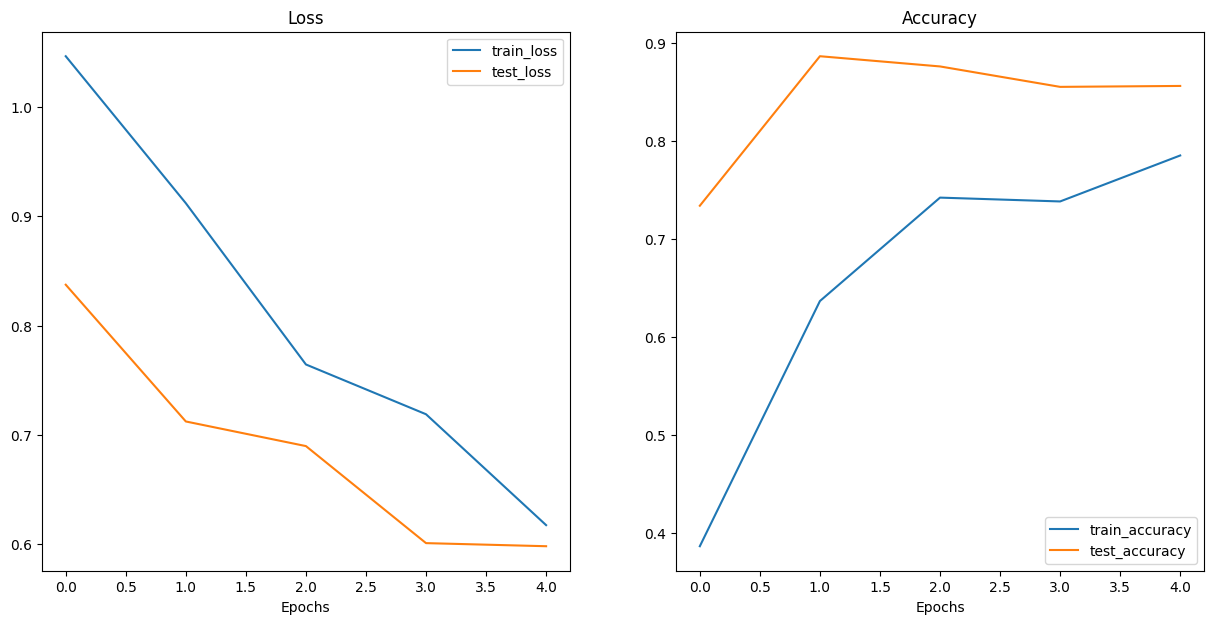

In [15]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

In [19]:
# make predictiong on testing data
from typing import List, Tuple

from PIL import Image # for visualization
#define train funciton
def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names=list[str],
    image_size: Tuple[int, int] =(224, 224),
    transform : torchvision.transforms=None,
    device: torch.device=device):

  # open  image
  img =Image.open(image_path)

  # create image transformation
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
          transforms.Resize(image_size),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
      ])

  model.to(device)

  # turn on model inference mode
  model.eval()
  with torch.inference_mode():
    transformed_image=image_transform(img).unsqueeze(dim=0) # match the input size
    # make predict
    target_image_pred=model(transformed_image.to(device))

  target_image_pred_prob =torch.softmax(target_image_pred, dim=1)
  target_image_pred_label=torch.argmax(target_image_pred_prob,dim=1)

  plt.figure()
  plt.imshow(img)
  plt.title(f'Pred:{class_names[target_image_pred_label]}|Prob: {target_image_pred_prob.max():.3f}')
  plt.axis(False)

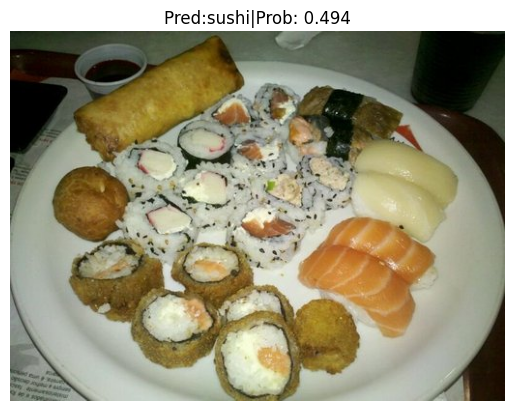

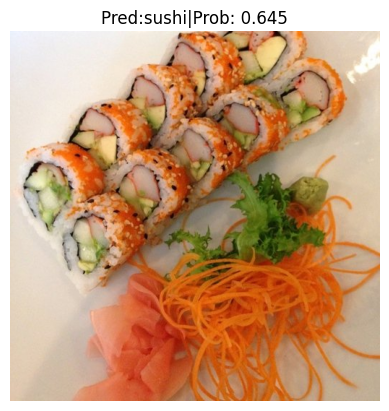

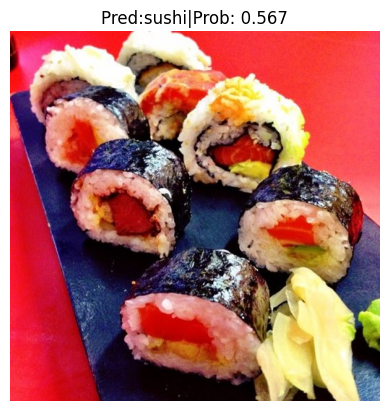

In [21]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      transform=weights.transforms(),
                      image_size=(224, 224))

In [27]:
# excise for 06
#make predication on the entire test dataset with tht model

from tqdm.auto import tqdm
test_pred=[]
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y= X.to(device), y.to(device)
    pred = model(X)
    pred_probs=torch.softmax(pred, dim=1)
    pred_label=torch.argmax(pred_probs,dim=1)
    test_pred.append(pred_label)

test_pred = torch.cat(test_pred).cpu()
test_pred

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [28]:
# to make a confusion matrix
# get the truth label

true_label=torch.cat([y for X, y in tqdm(test_dataloader)]).cpu()
true_label

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [33]:
import sklearn
from sklearn.metrics import confusion_matrix
confusion_matrix(test_pred, true_label)

array([[23,  1,  4],
       [ 1, 16,  1],
       [ 1,  2, 26]])

In [45]:
#excise # 2
#get teh 'most wrong' of the predict on test dataset and plot the 5 'most wrong ' iamge
import pandas as pd
from PIL import Image
test_data_paths=list(Path(test_dir).glob('*/*.jpg'))
test_labels=[path.parent.stem for path in test_data_paths]
#print(test_data_paths)
# transform=auto_transforms

results=[]
for path in test_data_paths:
  df={}
  df['sample']=path
  class_name=path.parent.stem
  df['label']=class_name
  #prep image for pred
  img =Image.open(path)
  transformed_img=transform(img).unsqueeze(0)
  model.eval()
  with torch.inference_mode():
    pred=model(transformed_img.to(device))
    pred_probs=torch.softmax(pred, dim=1)
    pred_label=torch.argmax(pred_probs, dim=1)
    pred_class = class_names[pred_label.cpu()]

    df['prediction']=pred_class
    df['pred_prob']=pred_probs.max().cpu().item()
    df['correct']= class_name ==pred_class
  results.append(df)


In [46]:
results

[{'sample': PosixPath('data/pizza_steak_sushi/test/sushi/1742201.jpg'),
  'label': 'sushi',
  'prediction': 'sushi',
  'pred_prob': 0.5667928457260132,
  'correct': True},
 {'sample': PosixPath('data/pizza_steak_sushi/test/sushi/499605.jpg'),
  'label': 'sushi',
  'prediction': 'sushi',
  'pred_prob': 0.6817716360092163,
  'correct': True},
 {'sample': PosixPath('data/pizza_steak_sushi/test/sushi/1987407.jpg'),
  'label': 'sushi',
  'prediction': 'sushi',
  'pred_prob': 0.5654692649841309,
  'correct': True},
 {'sample': PosixPath('data/pizza_steak_sushi/test/sushi/2521706.jpg'),
  'label': 'sushi',
  'prediction': 'pizza',
  'pred_prob': 0.5451217293739319,
  'correct': False},
 {'sample': PosixPath('data/pizza_steak_sushi/test/sushi/3177743.jpg'),
  'label': 'sushi',
  'prediction': 'sushi',
  'pred_prob': 0.44782453775405884,
  'correct': True},
 {'sample': PosixPath('data/pizza_steak_sushi/test/sushi/1172255.jpg'),
  'label': 'sushi',
  'prediction': 'sushi',
  'pred_prob': 0.49399

In [47]:
test_df=pd.DataFrame(results)
test_df

,sample,label,prediction,pred_prob,correct
0,data/pizza_steak_sushi/test/sushi/1742201.jpg,sushi,sushi,0.566793,True
1,data/pizza_steak_sushi/test/sushi/499605.jpg,sushi,sushi,0.681772,True
2,data/pizza_steak_sushi/test/sushi/1987407.jpg,sushi,sushi,0.565469,True
3,data/pizza_steak_sushi/test/sushi/2521706.jpg,sushi,pizza,0.545122,False
4,data/pizza_steak_sushi/test/sushi/3177743.jpg,sushi,sushi,0.447825,True
...,...,...,...,...,...
70,data/pizza_steak_sushi/test/pizza/1925494.jpg,pizza,pizza,0.754693,True
71,data/pizza_steak_sushi/test/pizza/2111981.jpg,pizza,pizza,0.819505,True
72,data/pizza_steak_sushi/test/pizza/398345.jpg,pizza,pizza,0.791652,True
73,data/pizza_steak_sushi/test/pizza/1687143.jpg,pizza,pizza,0.696040,True


In [49]:
top_5_wrong= test_df.sort_values(by=['correct','pred_prob'], ascending=[True,False])[:5]

In [50]:
top_5_wrong

,sample,label,prediction,pred_prob,correct
3,data/pizza_steak_sushi/test/sushi/2521706.jpg,sushi,pizza,0.545122,False
57,data/pizza_steak_sushi/test/pizza/2508636.jpg,pizza,sushi,0.511781,False
20,data/pizza_steak_sushi/test/sushi/1245193.jpg,sushi,pizza,0.481049,False
21,data/pizza_steak_sushi/test/sushi/343036.jpg,sushi,pizza,0.462312,False
39,data/pizza_steak_sushi/test/steak/1627703.jpg,steak,pizza,0.445572,False


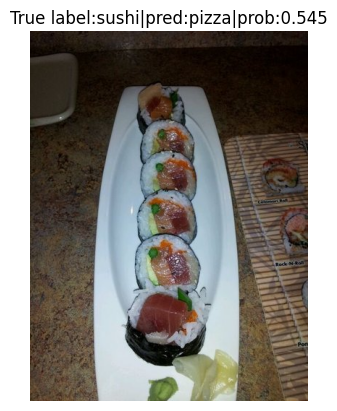

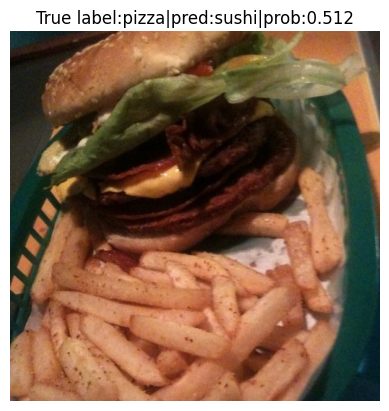

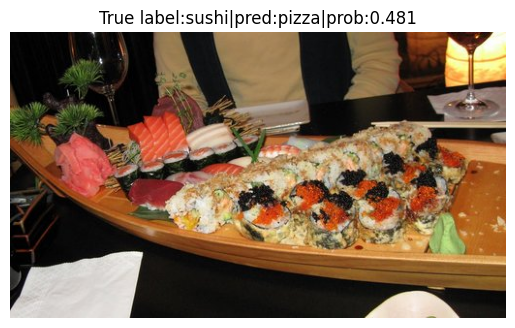

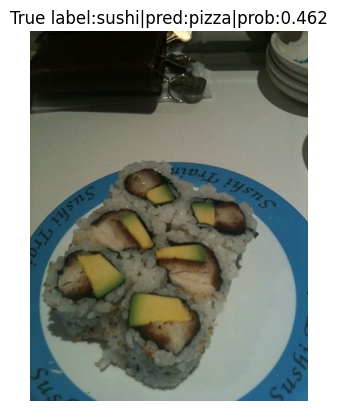

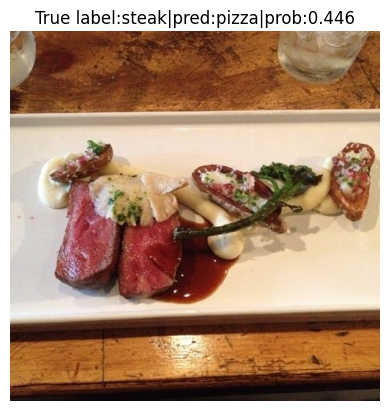

In [60]:
# print out the top five
import matplotlib.pyplot as plt
import torchvision

for row in top_5_wrong.iterrows():
  # read img into tensor
  #print(row[1][0])
  img= torchvision.io.read_image(str(row[1][0]))
  plt.figure()
  plt.imshow(img.permute(1,2,0)) # [heigh, width, channel] in matplotlib
  plt.title(f'True label:{row[1][1] }|pred:{row[1][2]}|prob:{row[1][3]:.3f}')
  plt.axis(False)
